In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import data
from tensorflow.keras import losses
from tensorflow.keras import layers, Input, Model


import cv2
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

## 1. 데이터 준비

In [2]:
data_path = "./data/cityscapes/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


- [cv2.IMREAD_COLOR](https://jinjeecode.tistory.com/19)
    - cv2.IMREAD_COLOR : 이미지를 컬러로 로드하며 투명한 부분은 모두 무시합니다. default 입니다.

    - cv2.IMREAD_GRAYSCALE : 이미지를 흑백으로 로드합니다.

    - cv2.IMREAD_UNCHANGED : 알파채널을 포함하여 이미지를 원본 그대로 로드합니다.


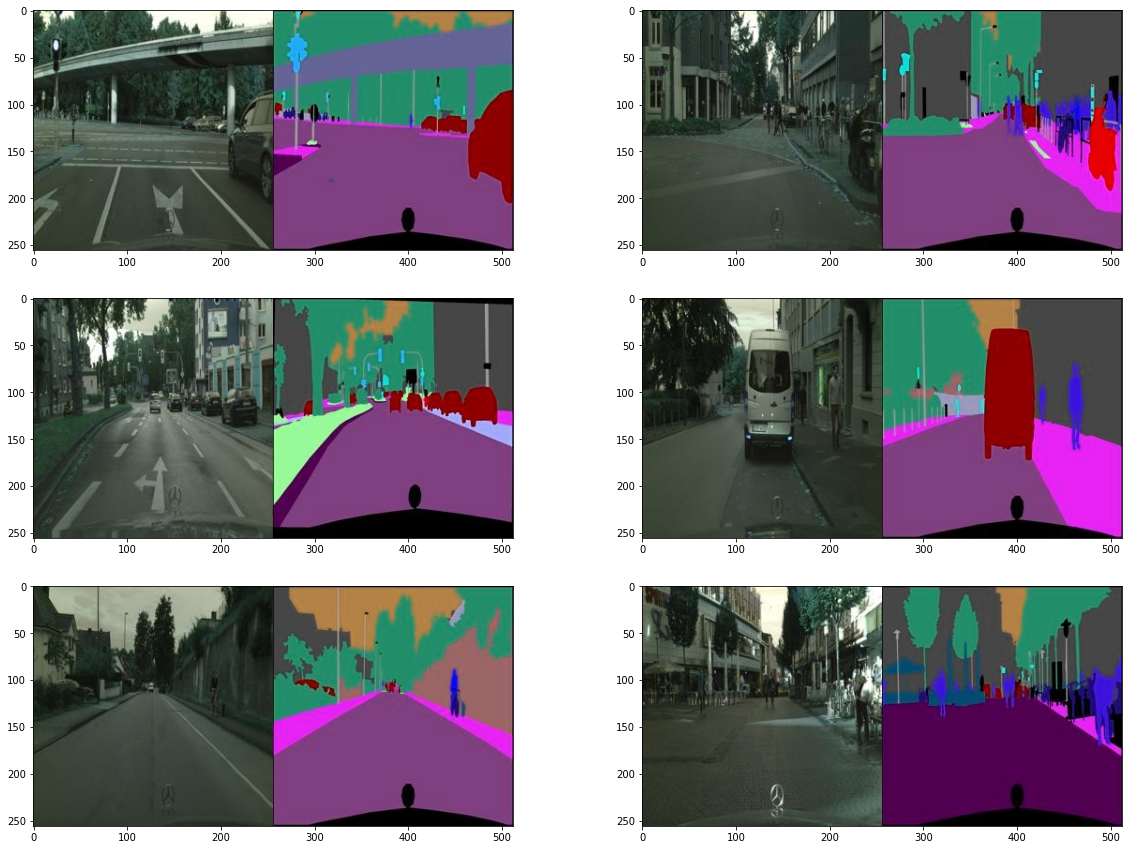

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

## 2. 데이터 전처리

- [tf.io.read_file(path)](https://www.tensorflow.org/api_docs/python/tf/io/read_file)
    - with open문을 사용하는 것과 동일하며 불러온 객체는 tf.Tensor 입니다.
    - str 타입의 텐서로 내용은 파일의 전체 내용입니다.

- [tf.image.decode_image()](https://www.tensorflow.org/api_docs/python/tf/io/decode_image)
    - 입력은 인코딩된 바이트 이미지이고 색채널의 수를 정할 수 있습니다.
    - returns : [height, width, num_channels]


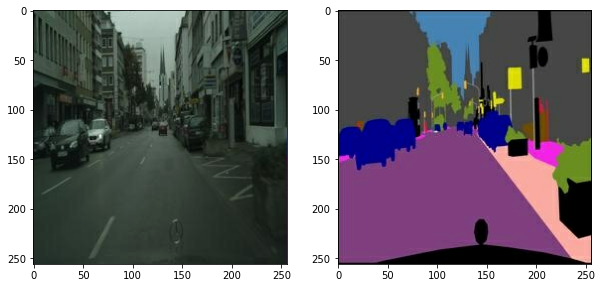

In [4]:
# -1 과 1 사이의 값으로 scaling 시킵니다.
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

## 3. Data augmentation

[tf.pad()](https://www.tensorflow.org/api_docs/python/tf/pad)
   - 이미지를 미리 padding을 해줍니다. 
   - tf.pad(t, paddings, "CONSTANT")  
   [[0, 0, 0, 0, 0, 0, 0],  
     [0, 0, 1, 2, 3, 0, 0],  
     [0, 0, 4, 5, 6, 0, 0],  
     [0, 0, 0, 0, 0, 0, 0]]

   - tf.pad(t, paddings, "REFLECT")  
   [[6, 5, 4, 5, 6, 5, 4],  
    [3, 2, 1, 2, 3, 2, 1],  
    [6, 5, 4, 5, 6, 5, 4],  
    [3, 2, 1, 2, 3, 2, 1]]

   - tf.pad(t, paddings, "SYMMETRIC")  
   [[2, 1, 1, 2, 3, 3, 2],  
      [2, 1, 1, 2, 3, 3, 2],  
      [5, 4, 4, 5, 6, 6, 5],  
      [5, 4, 4, 5, 6, 6, 5]]


[tf.image](https://www.tensorflow.org/api_docs/python/tf/image)
- tf.image_crop() 이미지의 무작위 지역을 지정한 크기로 잘라냅니다.
   
[tf.image.random_flip_left_right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right)
- 무작위의 데이터를 좌우반전을 시켜줍니다.
   
[tf.image.random_flip_up_down](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_up_down)
- 데이터의 상하반전을 시켜줍니다. 
  
  
[tf.image.rot90](https://www.tensorflow.org/api_docs/python/tf/image/rot90)
- 이미지의 각도를 회전시켜줍니다.

In [5]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 채널의 수가 6인 이유는 augmented 채널의 수 + 원본의 채널의 수
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

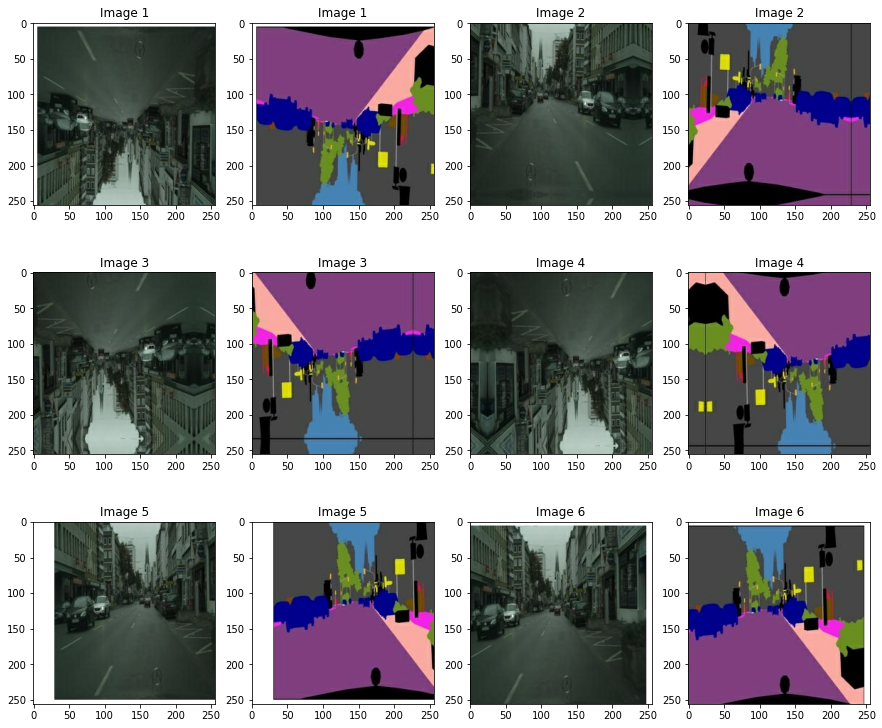

In [6]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

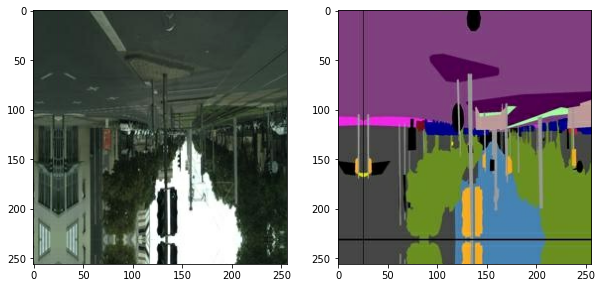

In [7]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## 4. 모델 구축

![image](https://user-images.githubusercontent.com/51338268/144788203-9161eb7a-b787-42c8-93a0-53b9af4ba04d.png)


### 4.1 Generator 모델

#### 4.1.1 Encoder

In [8]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

#### 4.1.2 decoder

In [9]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 512)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         4196352   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

#### 4.1.3 UNet - encoder decoder 모델

In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        #### decoder에 encoder 내용 skip - connection 연결 ###
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        #######################################################
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

### 4.2 Discriminator 모델

#### 기존 DCGAN의 Discriminator

![image](https://user-images.githubusercontent.com/51338268/144788377-6f4978f0-575a-4353-ac30-bde1f628baec.png)


DCGAN의 Discriminator는 하나의 확률값으로 해당 이미지의 진위여부를 판단합니다.

#### Pix2Pix의 Discriminator

![image](https://user-images.githubusercontent.com/51338268/144788561-5d34fc57-469f-43ab-8a7a-c67bb2162390.png)

기존의 DCGAN의 Discriminator는 하나의 확률값을 출력했지만 Pix2Pix의 Discriminator는 여러개의 값을 확률값을 출력하며 위의 그림의 경우 16개의 확률값을 출력합니다.

각 확률값은 각각의 receptive field 영역을 보고 있으며 그림의 파란색 박스에 대해서만 진짜와 가짜를 판별하는 확률값을 도출합니다.

최종적으로 여러 확률값들을 평균하여 최종 Discrminator의 출력을 생성하며 이러한 방법을 이미지의 일부(patch)만 이용한다고 하여 PatchGAN 이라고 부릅니다.

이러한 방법이 통하는 이유는 일반적으로 이미지에서 거리가 먼 두 픽셀의 연관성을 낮기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진위여부를 판별하는 것이 더 좋게 만들어 주는 것입니다.

In [11]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [12]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [13]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 256, 256, 6)  0           input_4[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate[0][0]          

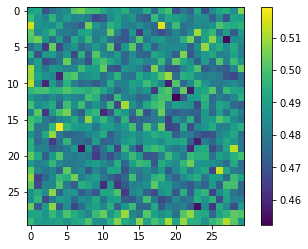

In [14]:
Discriminator().get_summary()
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

## 5. 모델 학습

In [15]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [16]:
EPOCHS = 100 #약 30분 정도 소요 됩니다.

generator = UNetGenerator()
discriminator = Discriminator()

g_losses = []
l1_losses = []
d_losses = []

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(colored, sketch)

    print(f"EPOCH[{epoch}]] \
    \nGenerator_loss:{g_loss.numpy():.4f} \
    \nL1_loss:{l1_loss.numpy():.4f} \
    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
    
    g_losses += [g_loss.numpy()]
    l1_losses += [l1_loss.numpy()]
    d_losses += [d_loss.numpy()]

EPOCH[1]]     
Generator_loss:1.7497     
L1_loss:0.1729     
Discriminator_loss:0.6843

EPOCH[2]]     
Generator_loss:2.5598     
L1_loss:0.2308     
Discriminator_loss:0.2134

EPOCH[3]]     
Generator_loss:1.7784     
L1_loss:0.1751     
Discriminator_loss:0.6460

EPOCH[4]]     
Generator_loss:0.6329     
L1_loss:0.1931     
Discriminator_loss:1.2342

EPOCH[5]]     
Generator_loss:1.7883     
L1_loss:0.1732     
Discriminator_loss:1.2625

EPOCH[6]]     
Generator_loss:1.5363     
L1_loss:0.1426     
Discriminator_loss:0.7801

EPOCH[7]]     
Generator_loss:1.5620     
L1_loss:0.1706     
Discriminator_loss:1.0018

EPOCH[8]]     
Generator_loss:0.9096     
L1_loss:0.1881     
Discriminator_loss:0.8454

EPOCH[9]]     
Generator_loss:2.1425     
L1_loss:0.1785     
Discriminator_loss:0.2965

EPOCH[10]]     
Generator_loss:2.4847     
L1_loss:0.1790     
Discriminator_loss:0.7187

EPOCH[11]]     
Generator_loss:2.1930     
L1_loss:0.1793     
Discriminator_loss:0.3474

EPOCH[12]]     
Gen

EPOCH[93]]     
Generator_loss:2.4143     
L1_loss:0.1772     
Discriminator_loss:0.5492

EPOCH[94]]     
Generator_loss:1.7948     
L1_loss:0.1937     
Discriminator_loss:0.2622

EPOCH[95]]     
Generator_loss:0.7004     
L1_loss:0.1456     
Discriminator_loss:0.8619

EPOCH[96]]     
Generator_loss:2.3956     
L1_loss:0.1591     
Discriminator_loss:1.2003

EPOCH[97]]     
Generator_loss:1.0864     
L1_loss:0.1684     
Discriminator_loss:0.7044

EPOCH[98]]     
Generator_loss:1.8458     
L1_loss:0.1455     
Discriminator_loss:1.0432

EPOCH[99]]     
Generator_loss:1.8861     
L1_loss:0.1617     
Discriminator_loss:0.7039

EPOCH[100]]     
Generator_loss:1.2020     
L1_loss:0.1508     
Discriminator_loss:0.8017



## 6. 모델 평가 및 검증

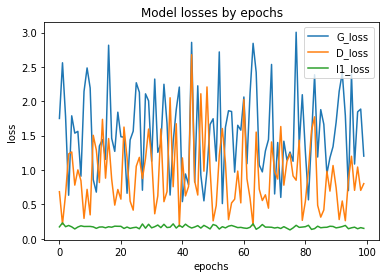

In [17]:
def loss_history(g_losses, l1_losses, d_losses):
    plt.plot(g_losses, label = "G_loss")
    plt.plot(d_losses, label = "D_loss")
    plt.plot(l1_losses, label = "l1_loss")
    plt.title("Model losses by epochs")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    
loss_history(g_losses, l1_losses, d_losses)

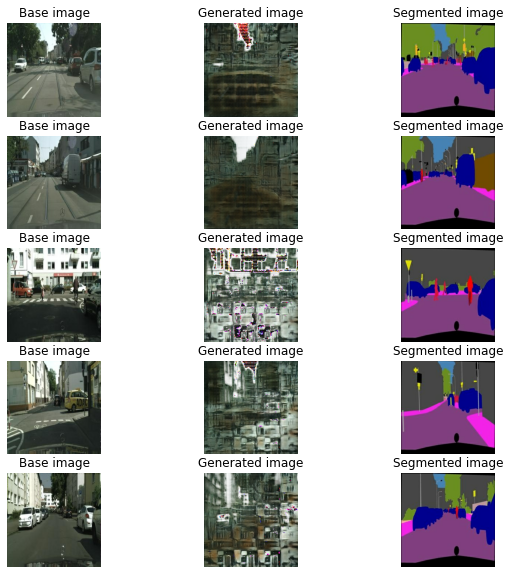

In [18]:
val_path = "./data/cityscapes/val/" 
img_paths = os.listdir(val_path)
num_vals = len(img_paths)

fig, axes = plt.subplots(num_vals, 3, figsize = (10, 10))

for idx in range(num_vals):
    f = val_path + img_paths[idx]
    sketch, colored = load_img(f)
    
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)
    
    base = axes[idx, 0]
    gene = axes[idx, 1]
    segm = axes[idx, 2]
    
    base.imshow(denormalize(sketch))
    base.axis("off")
    base.set_title("Base image")
    gene.imshow(pred[0])
    gene.axis("off")
    gene.set_title("Generated image")
    segm.imshow(denormalize(colored))
    segm.axis("off")
    segm.set_title("Segmented image")